In [1]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
# os.environ['THEANO_FLAGS']="device=cuda"

import numpy as np
import theano
import pickle

# from numba import njit, prange
from scipy.linalg import svd, qr, inv, pinv
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.linalg import lstsq



import theano.tensor as T
from theano.ifelse import ifelse
from theano.tensor.nlinalg import svd
from theano import function, shared
import arviz as az

from pymc_classes import LogLike, log_likelihood



In [2]:
np.__config__.show()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_info']
    libraries = ['openblas_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_info']
    libraries = ['openblas_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_lapack_info']
    libraries = ['openblas_lapack_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_lapack_info']
    libraries = ['openblas_lapack_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]


In [3]:
import pymc3 as pm
# from pymc3.ode import DifferentialEquation


path = r"C:\Users\dominik\Documents\Projects\Bilirubin\UV-Vis data"
# path = r"C:\Users\Dominik\Documents\MUNI\Organic Photochemistry\Projects\2019-Bilirubin project\UV-VIS\QY measurement\Photodiode\new setup"


data_led = np.loadtxt(path + r'\LED sources.txt', delimiter='\t', skiprows=1)

LED_355 = data_led[:, 1] / np.trapz(data_led[:, 1])
LED_375 = data_led[:, 2] / np.trapz(data_led[:, 2])
LED_405 = data_led[:, 3] / np.trapz(data_led[:, 3])
LED_420 = data_led[:, 4] / np.trapz(data_led[:, 4])
LED_450 = data_led[:, 5] / np.trapz(data_led[:, 5])
LED_470 = data_led[:, 6] / np.trapz(data_led[:, 6])
LED_490 = data_led[:, 7] / np.trapz(data_led[:, 7])

In [4]:
# pythonic version
def _lstsq_D(C, D):
    U, S, VT = np.linalg.svd(C, full_matrices=False)

    Sr = S[S > S[0] * 1e-10]
    Ur = U[:, :Sr.shape[0]]

    CC_plus_D = Ur.dot(Ur.T).dot(D)

    return CC_plus_D

def Phi(phis, lambda_C=400, wavelengths=None):
    assert isinstance(phis, (list, np.ndarray))
    return sum(par * ((lambda_C - wavelengths) / 100) ** i for i, par in enumerate(phis))

# C, D = T.dmatrix('C'), T.dmatrix('D')

# # theano version
# U, S, VT = svd(C, full_matrices=0, compute_uv=1)

# Sr = S[S > S[0] * 1e-8]
# Ur = U[:, :Sr.shape[0]]
# CC_plus_D = Ur.dot(Ur.T).dot(D)

# _lstsq_D = function([C, D], CC_plus_D)



Text(0, 0.5, 'Absorbance')

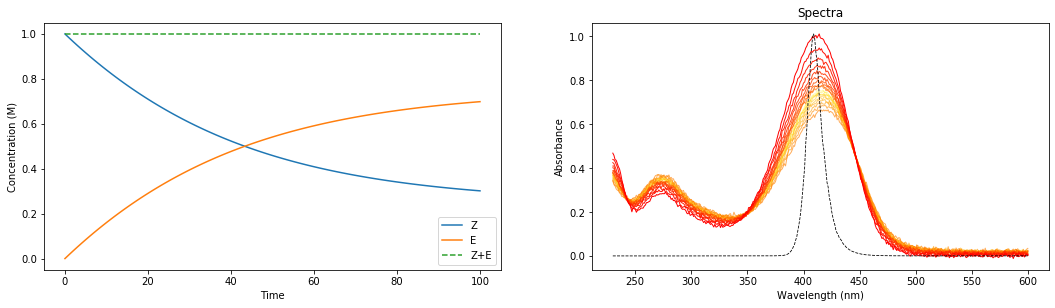

In [5]:
eps = np.loadtxt(r'C:\Users\dominik\Documents\GitHub Repositories\Jupyter-Tutorials\Photoreaction kinetics\fit-A.csv',
                 delimiter=',', skiprows=1)

# eps = np.loadtxt(r'C:\Users\Dominik\Documents\MUNI\Organic Photochemistry\Projects\2019-Bilirubin project\UV-VIS\QY measurement\Photodiode\new setup\spectra_fit.csv',
#                  delimiter=',', skiprows=1)
ST = eps[:, [1, 2]].T  # ST is a matrix of n x w
ST /= ST.max()

wavelengths = eps[:, 0] + 230
N = 100
times = np.linspace(0, 100, N)
# k = 0.05

# C = np.exp(-k * times[:, None])
# D = C @ ST[None, :]

# D = np.random.normal(D, 0.05)




def simulate_one_QY(times, K, eps, q_tot, c0, V, I_source):
    
    const = np.log(10)

    def dc_dt(c, t):
        c_eps = c[:, None] * eps  # hadamard product
        c_dot_eps = c_eps.sum(axis=0)

        q = c_eps * np.where(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2,
                             (1 - np.exp(-c_dot_eps * const)) / c_dot_eps) * I_source

        integral = (q.sum(axis=1) - (q[:, 0] + q[:, -1]) / 2)

        return q_tot / V * K.dot(integral[:, None]).squeeze()

    return odeint(dc_dt, c0, times)

def simulate(times, K, eps, q_tot, c0, V, I_source):

    const = np.log(10)

    def dc_dt(c, t):
        c_eps = c[:, None] * eps  # hadamard product
        c_dot_eps = c_eps.sum(axis=0)

        q = c_eps * np.where(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2,
                             (1 - np.exp(-c_dot_eps * const)) / c_dot_eps) * I_source

        product = np.matmul(K, q.T[..., None]).squeeze()  # w x n x 1

        return q_tot / V * (product.sum(0) - (product[0] + product[-1]) / 2)

    return odeint(dc_dt, c0, times)

def dc_dt_py(c, t):
#     q0 = p[0] 
    c_eps = c[:, None] * eps  # hadamard product
    c_dot_eps = c_eps.sum(axis=0)
    
    q = c_eps * np.where(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2,
                                     (1 - np.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
    product = np.matmul(K, q.T[..., None]).squeeze()  # w x n x 1
    
    return q0 / V * (product.sum(0) - (product[0] + product[-1]) / 2)
    
#     return q0 / V * np.trapz(product, axis=0).squeeze()

# @njit(fastmath=True, parallel=False)
# def dc_dt_numba(c, t):
#     c_eps = c.reshape((-1, 1)) * eps  # hadamard product
#     c_dot_eps = c_eps.sum(0)
    
#     fk_factor = np.zeros_like(c_dot_eps)
#     for i in prange(c_dot_eps.shape[0]):
#         if c_dot_eps[i] < 0.001:
#             fk_factor[i] = const - c_dot_eps[i] * const * const / 2
#         else:
#             fk_factor[i] = (1 - np.exp(-c_dot_eps[i] * const)) / c_dot_eps[i]
            
#     q = c_eps * fk_factor * I_source
    
#     product = np.zeros((c_dot_eps.shape[0], c.shape[0]))
#     for i in prange(c_dot_eps.shape[0]):
#         product[i] = K[i].dot(q[:, i])
        
#     return q0 / V * (product.sum(0) - (product[0] + product[-1]) / 2)
    

def dc_dt(c, t, p):
    q0 = p[0] 

    c_eps = c[:, None] * eps  # hadamard product
    
    c_dot_eps = c_eps.sum(axis=0)
    
#     x_abs = c_eps * T.switch(T.lt(c_dot_eps, 0.001), const - c_dot_eps * const * const / 2, 
#                    (1 - T.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
    x_abs = c_eps * T.switch(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2, 
                   (1 - T.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
#     n = x_abs.T[:, :, None]
    
    _product, _ = theano.scan(lambda a, b: T.dot(a, b), sequences=[K, x_abs.T[..., None]])
    
#     product = T.batched_dot(K, x_abs.T[..., None])

    return q0 / V * (_product.sum(axis=0) - (_product[0, ...] + _product[-1, ...]) / 2).squeeze()

#     x_abs = c_eps * np.where(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2, (1 - np.exp(-c_dot_eps * const)) / c_dot_eps) * I_source

#     # w x n x n   x   w x n x 1
#     product = np.matmul(K, x_abs.T[..., None])  # w x n x 1

#     return q0 / V * np.trapz(_product, axis=0).squeeze()


# t_y = T.vector("y", dtype='float64')
# t_t = T.scalar("t", dtype='float64')
# t_p = T.vector("p", dtype='float64')
# # K = T.tensor3("_K", dtype='float64')


# _func_theano = dc_dt(t_y, t_t, t_p)
# func = function([t_y, t_t, t_p], _func_theano, on_unused_input='warn')

# theano.config.blas.ldflags='-lmkl_rt'


# c = T.tensor3('a', dtype='float64')
# f = T.tensor3('b', dtype='float64')

# _product, _ = theano.scan(lambda a, b: T.dot(a, b), sequences=[c, f])

# _dot_func = function([c, f], _product)

# b = func([1, 0], 0, [1], K)
# b
# np.dot(K[0], b[50]).shape

# _dot_func(K, b).squeeze()

# np.matmul(K, func([1, 0], 0, [1])).squeeze().shape
# K
# K.shape, func([1, 0], 0, [1]).shape

# C = odeint(func, [c0, 0], times, args=((q0,), K))
# C_py = odeint(dc_dt_py, [c0, 0], times, args=((q0,), K))

# np.allclose(C, C_py, rtol=1e-8)

# phi = Phi([0.2], 400, wavelengths)
phi_ZE = Phi([0.2, 0], 400, wavelengths)
phi_EZ = Phi([0.1, 0], 400, wavelengths)

q0, V, c0 = 1e-1, 1, 1
I_source = LED_405

_0 = np.zeros(wavelengths.shape) if isinstance(phi_ZE, np.ndarray) else 0

K = np.asarray([[-phi_ZE, phi_EZ],
                [+phi_ZE, -phi_EZ]])

if isinstance(phi_ZE, np.ndarray):
    K = np.transpose(K, (2, 0, 1))

const = np.log(10)
eps = ST


C1 = simulate(times, K, eps, q0, [c0, 0], V, LED_405)

# phi_EZ = 0.12
# K = np.asarray([[-phi_ZE, phi_EZ],
#                 [+phi_ZE, -phi_EZ]])

C2 = simulate(times, K, eps, q0, [0, c0], V, LED_450)

# %timeit C = simulate(times, K, eps, q0, [c0, 0], V, I_source)

# %timeit C_numba = odeint(dc_dt_numba, [c0, 0], times)   #, args=((q0,),))

# np.allclose(C, C_numba, rtol=1e-8)


names = ['Z', 'E', 'HL', 'Unknown']

plt.rcParams['figure.figsize'] = [18, 10]
plt.subplot(2, 2, 1)
for i in range(2):
    plt.plot(times, C1[:, i], label=names[i])
plt.plot(times, C1.sum(axis=1), label='+'.join(names[0:2]), linestyle='--')
plt.xlabel('Time')
plt.ylabel('Concentration (M)')
plt.legend()

D = np.vstack((C1, C2)) @ ST  # compute data matrix
D_obs = np.random.normal(D, 0.005)


# plot time-dependent spectra
t = D.shape[0]
plt.subplot(2, 2, 2)
for i in reversed(range(0, t, 10)):
    plt.plot(wavelengths, D_obs[i], color=(1, i/t, 0, (t-i/1.4)/t), lw=1)
plt.plot(wavelengths, D_obs.max() * I_source / I_source.max(), label='irrsource', linestyle='--', color='black', lw=0.8)
plt.title("Spectra")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')


In [6]:
times.shape, D.shape



((100,), (200, 371))

In [10]:
ll = LogLike(log_likelihood, D_obs, times, wavelengths, ST, [LED_405, LED_450], q0, V, c0)


phis = np.linspace(0.01, 0.5, 20)
phis2 = np.linspace(0.01, 0.5, 20)


likelihoods = np.zeros((phis.shape[0], phis2.shape[0]))
grads = []
spectra = []

# for i in range(len(phis)):
#     for j in range(len(phis2)):
#         params = np.asarray([phis[i], phis2[j]])
#         likelihoods[i][j], eps_opt = ll._log_like(params)
#         spectra.append(eps_opt)
    

# for phi in phis:
#     params = np.asarray([phi, 0])
#     likelihoods.append(ll._log_like(params))
#     grads.append(ll._grads(params))

params = np.asarray([0.2, 0,  0.1, 0])
ll  = ll._log_like(params)

print(ll)
# plt.rcParams['figure.figsize'] = [8, 5]
# plt.plot(wavelengths, eps_opt.T)
# plt.show()

# phi, phi1 = np.random.random(20), (np.random.random(50) - 0.5) * 0.2

# vals = []
# # for i in range(1, 50):
#     vals.append(ll.log_likelihood(np.asarray([0.1, 0.01]), n_MCR_iter=i))

# for p1, p2 in zip(phi, phi1):
#     params = np.asarray([p1, p2])
#     vals.append(ll.log_likelihood(params, n_MCR_iter=2))

# for p1, p2 in zip(phi, phi1):
#     params = np.asarray([p1, p2])
#     vals1.append(ll.log_likelihood(params, n_MCR_iter=2))
    
# vals, vals1 = np.asarray(vals), np.asarray(vals1)


-9290.478222006095


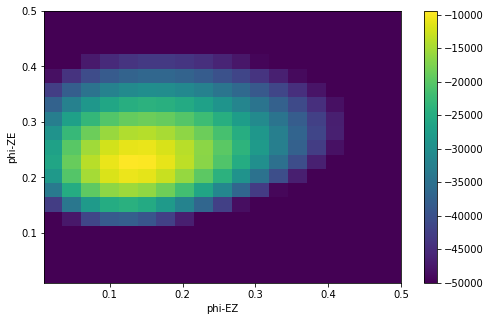

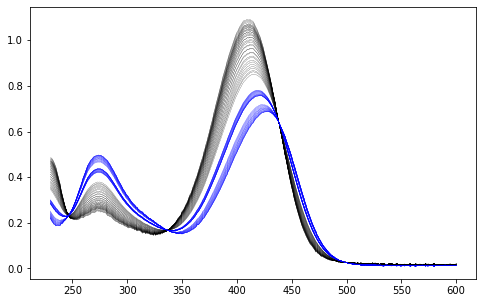

In [32]:
x, y = np.meshgrid(phis, phis2)
likelihoods_plot = likelihoods.copy()
# likelihoods_plot[likelihoods_plot < -1e10] = -40000

plt.rcParams['figure.figsize'] = [8, 5]
plt.pcolormesh(x, y, likelihoods_plot, cmap='viridis', vmin = -50000, vmax=likelihoods_plot.max())
plt.colorbar()
plt.ylabel('phi-ZE')
plt.xlabel('phi-EZ')
plt.show()
# grads = np.asarray(grads)

# plt.rcParams['figure.figsize'] = [8, 5]
# plt.plot(phis, likelihoods)
# plt.show()

# plt.plot(phis, grads[:, 0])
# plt.show()
# # grads
# x[0]
sp = np.asarray(spectra)

plt.plot(wavelengths, sp[::10, 0, :].T, color='black', lw=0.2)
plt.plot(wavelengths, sp[::10, 1, :].T, color='blue', lw=0.2)


plt.show()


In [7]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(wavelengths, ll.calls[0][1].T)
plt.plot(wavelengths, ST.T, color='black', ls='--')
plt.show()

AttributeError: 'LogLike' object has no attribute 'calls'

In [14]:
# create our Op
    
logl = LogLike(log_likelihood, D_obs, times, wavelengths, ST, [LED_405, LED_450], q0, V, c0)

def _model_func(p):
    return logl(p)

with pm.Model() as model:

    # Define priors
    ZE = pm.Uniform('ZE', lower=0, upper=1, testval=0.2)
    EZ = pm.Uniform('EZ', lower=0, upper=1, testval=0.1)
    
    ZE1 = pm.Normal('ZE1', mu=0, sd=0.1, testval=0)
    EZ1 = pm.Normal('EZ1', mu=0, sd=0.1, testval=0.0)

    params = T.as_tensor_variable([ZE, ZE1, EZ, EZ1])

    pm.DensityDist('likelihood', _model_func, observed={'p': params})

#     for RV in model.basic_RVs:
#         print(RV.name, RV.logp(model.test_point))
#     model.check_test_point()
    
    trace = pm.sample(1000, tune=50, discard_tuned_samples=True, chains=2, cores=1)


    
#     # Inference!
#     prior = pm.sample_prior_predictive()
#     trace = pm.sample(5000, tune=1000, cores=6) # draw 3000 posterior samples using NUTS sampling
#     posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [EZ1, ZE1, EZ, ZE]
Sampling chain 0, 0 divergences:  28%|██▊       | 299/1050 [1:31:58<3:51:00, 18.46s/it]
The acceptance probability does not match the target. It is 0.6572018173604169, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


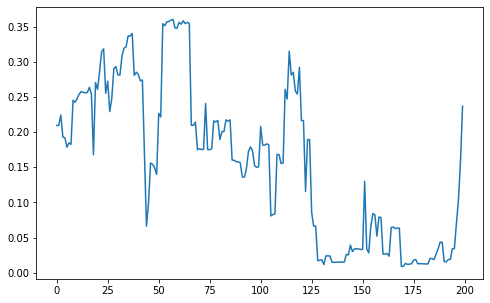

In [44]:
# logl.calls.__len__()
# plt.rcParams['figure.figsize'] = [8, 5]
# plt.plot(wavelengths, logl.ST_opts[1400].T)
# plt.plot(wavelengths, ST.T, color='black', ls='--')
# # plt.show()
# all_phis = np.asarray([logl.calls[i][0] for i in range(len(logl.calls))])

# # all_phis
# _ = plt.hist(trace['phi'], bins=100, range=(0.18, 0.22))
plt.rcParams['figure.figsize'] = [8, 5]            
plt.plot(trace['EZ'])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend

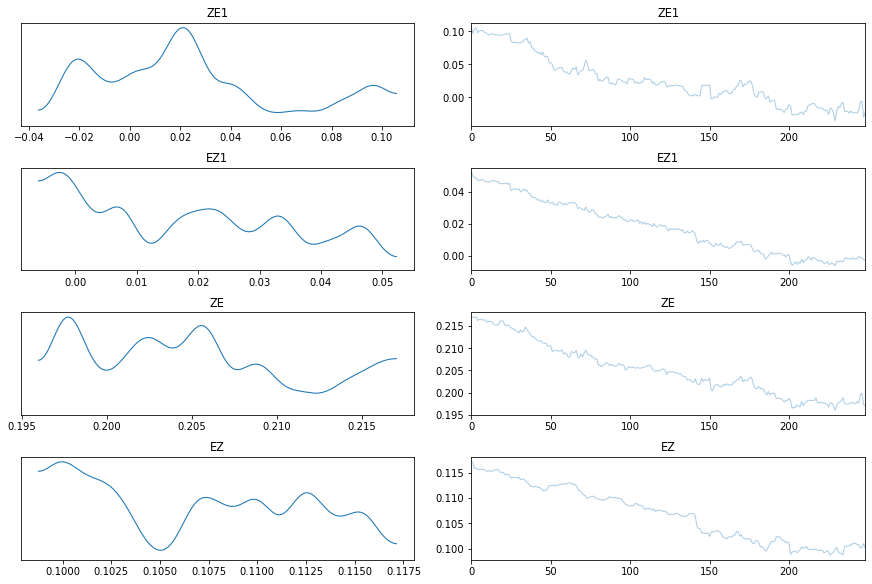

In [15]:

_ = pm.traceplot(trace)

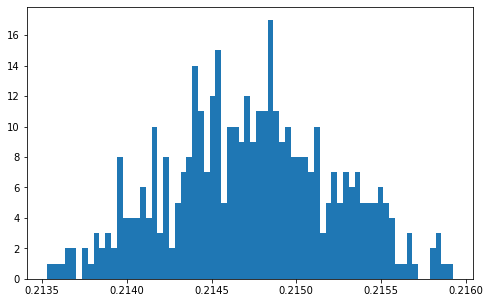

In [30]:
plt.rcParams['figure.figsize'] = [8, 5]
_ = plt.hist(trace['ZE'], bins=70)
plt.show()
# _ = plt.hist(trace['phi1'], bins=70)

In [139]:
data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002350B16DA48>,
      dtype=object)

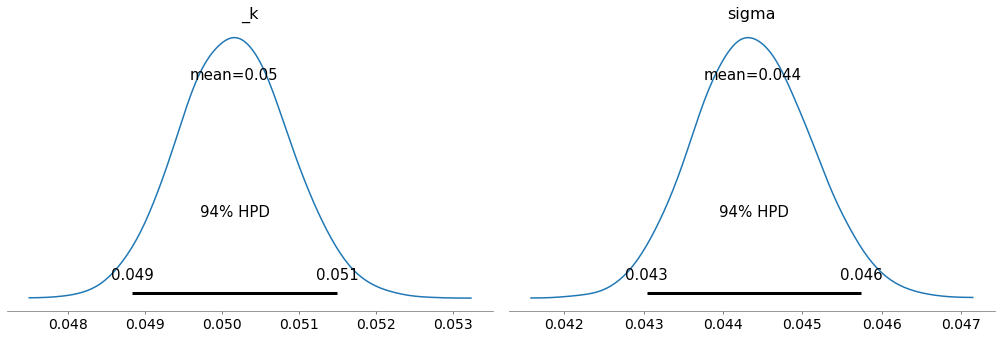

In [140]:
# pm.traceplot(trace[:])
az.plot_posterior(data)

In [126]:
from scipy.linalg import lstsq

trace["_k"].shape
k_samples = trace["_k"]

# k_samples.std()
Cs = np.exp(-k_samples * times[:, None])

STs = np.zeros((k_samples.shape[0], wls.shape[0]))

for i in range(k_samples.shape[0]):
    STs[i] = lstsq(Cs[:, i][:, None], D)[0]

# Cs[:, i].shape, D.shape

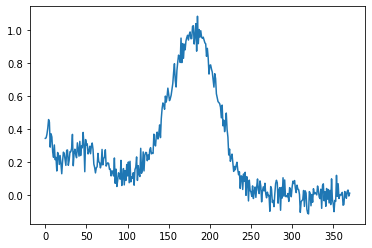

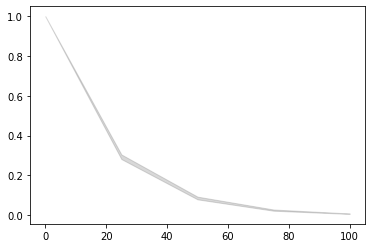

In [131]:
ST_avrg = STs.mean(axis=0)
Cs_avrg = Cs.mean(axis=1)

q_1, q_32, q_68, q_99 = np.quantile(STs, [0.01, 0.32, 0.68, 0.99], axis=0)
q_1, q_32, q_68, q_99 = np.quantile(Cs, [0.01, 0.32, 0.68, 0.99], axis=1)


plt.plot(wls,  ST_avrg)
# plt.fill_between(wls, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

plt.show()

# plt.plot(times, Cs_avrg.squeeze())
plt.fill_between(times, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

plt.show()


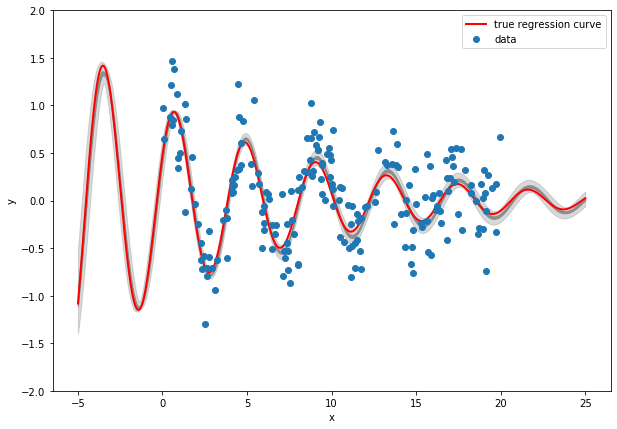

In [7]:
plt.figure(figsize=(10, 7))



# slope_samples = trace[100:]['slope']
# int_samples = trace[100:]['intercept']


# a0_samples = trace[100:]['a0']
# a1_samples = trace[100:]['a1']
# a2_samples = trace[100:]['a2']
# #a3_samples = trace[100:]['a3']


_x = np.linspace(-5, 25, 500)

# curves = a0_samples[:, None] + a1_samples[:, None] * _x[None, :] + a2_samples[:, None] * _x[None, :] ** 2#  + a3_samples[:, None] * _x[None, :] ** 3

curves = _model([a0_samples[:, None], a1_samples[:, None], a2_samples[:, None]], _x[None, :])


# lines = slope_samples[:, None] * _x[None, :] + int_samples[:, None]

# plt.plot(x, lines[::100].T, lw=0.1, color='gray')

true_y = _model(theta, _x)
plt.plot(_x, true_y, label='true regression curve', lw=2., c='r')

q_1, q_32, q_68, q_99 = np.quantile(curves, [0.01, 0.32, 0.68, 0.99], axis=0)


# slope_avrg = slope_samples.mean()
# int_avrg = int_samples.mean()
# line_avrg = slope_avrg  * _x + int_avrg

plt.fill_between(_x, q_32, q_68, color=(0.5, 0.5, 0.5, 0.8))
plt.fill_between(_x, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

# plt.fill_between(_x, true_y + 2 * stds, true_y - 2 * stds, color=(0.5, 0.5, 0.5, 0.5))
# plt.fill_between(_x, true_y + 3 * stds, true_y - 3 * stds, color=(0.5, 0.5, 0.5, 0.3))

# plt.plot(_x, _model([a0_samples.mean(), a1_samples.mean(), a2_samples.mean()], _x), label='fit', lw=2., c='b')

plt.plot(x, y, 'o', label='data')



# plt.title('Posterior predictive regression lines')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 2)


plt.show()


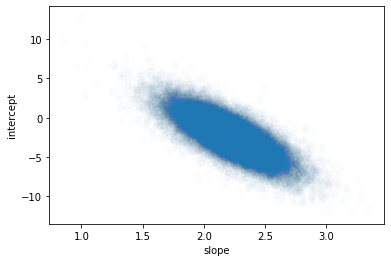

In [9]:
plt.plot(slope_samples[::1], int_samples[::1], 'o', alpha=0.01)
plt.xlabel('slope')
plt.ylabel('intercept')
plt.show()

In [86]:
samples = poisson_param.random(size=500000)

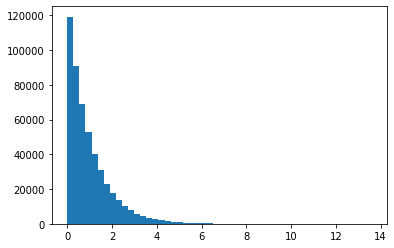

In [90]:
res = plt.hist(samples, bins=50, histtype="stepfilled")

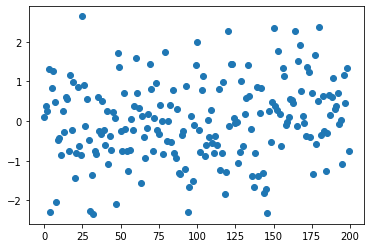

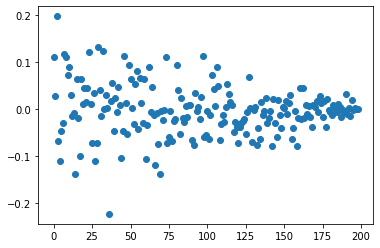

In [37]:
x = np.random.normal(0, 1, size=200)

corr =np.correlate(x, x, mode='full')
corr /= corr.max()
corr = corr[corr.size // 2 + 1:]

plt.plot(x, 'o')
plt.show()
plt.plot(corr, 'o')